In [1]:
import numpy as np
import matplotlib.pyplot as plt
import glob
import cv2
import csv
from keras.models import Model, Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.layers.normalization import batch_normalization
import os
import seaborn as sns
from datetime import datetime

2023-04-07 22:40:01.424958: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# Set up folder
SIZE = 256 #Size of the images this model will deal with
IMDIM = 1
Filters = 16

In [3]:
# Set up folder, unless it is already set up
p = os.path.abspath('.')
resized_dir = os.path.join(p, f'{SIZE}')
if not os.path.exists(resized_dir):
    os.mkdir(resized_dir)
    print(f"{resized_dir} created")
else:
    print(f"{resized_dir} already exists")

# Resize images and write them into folder, unless they are alrady there
for file in glob.glob('./Thresholded/*'):
	filename = file.split('/')[-1]
	new_name = os.path.join(resized_dir, filename)
	if not os.path.exists(new_name):
		img = cv2.imread(file, cv2.IMREAD_COLOR)
		img = cv2.resize(img, (SIZE,SIZE))
		cv2.imwrite(new_name, img)

# Read filenames in the folder
image_names = []
labels = []

for file in glob.glob(f'{resized_dir}/*.jpg'):
	filename = file.split('/')[-1]
	num_colonies = int(filename.split('-')[2].strip().split('.')[0])
	if num_colonies == 0:
		labels.append(0)
	else:
		labels.append(1)
	image_names.append(filename)

image_names = np.array(image_names) #  Array with image nbames
labels = np.array(labels)			#  Array with binary labels

#  Make two arrays with filenames: one for positive and one for negative images
pos_im_files = [image_names[i] for i in range(image_names.shape[0]) if labels[i]]
pos_im_files = np.array(pos_im_files)
neg_im_files = [image_names[i] for i in range(image_names.shape[0]) if not labels[i]]
neg_im_files = np.array(neg_im_files)
num_pos = pos_im_files.shape[0]
num_neg = neg_im_files.shape[0]
print(f'Full dataset: {num_pos} images with bacteria and {num_neg} without')

#  There are ~10x positive than negative.
#  For initital training let's get all positive and equal number of negative
#  For that:
#  (1) Index files of randomly selected negative images
np.random.seed(0) # For reproducibility
idx = np.random.choice(np.arange(neg_im_files.shape[0]), 3*num_pos, replace = False)
#  (2) Apply this index to the array of image names
neg_selected_files = neg_im_files[idx]
print(f"{pos_im_files.shape[0]}pos selected and {neg_selected_files.shape[0]} negative selected")

/home/art_usr/source_code/CFU_counter/256 already exists
Full dataset: 315 images with bacteria and 3428 without
315pos selected and 945 negative selected


In [4]:
# Read the positive files, only red channel
# Also add flipped image
print("Reading positive images...")
images = []
new_labels = []
for file_name in pos_im_files:
    file = os.path.join(resized_dir, file_name)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    images.append(img[:,:,2])
    new_labels.append(1)
    img_flipped_vert = cv2.flip(img[:,:,2], 0)
    images.append(img_flipped_vert)
    new_labels.append(1)
    img_flipped_hor = cv2.flip(img[:,:,2], 1)
    images.append(img_flipped_hor)
    new_labels.append(1)

print("Reading negative images...")
for file_name in neg_selected_files:
    file = os.path.join(resized_dir, file_name)
    img = cv2.imread(file, cv2.IMREAD_COLOR)
    images.append(img[:,:,2])
    new_labels.append(0)

images = np.array(images)
new_labels = np.array(new_labels)

# Now shuffle the images and labels
print("Suffling the dataset ....")
num_datapoints = images.shape[0]
indices = np.arange(num_datapoints)
shuffled_indices = np.random.permutation(indices)
X_shuffled = images[shuffled_indices]
y_shuffled = new_labels[shuffled_indices]

#  Make array shape compatible with keras Conv2D layers
X_shuffled = X_shuffled.reshape(X_shuffled.shape[0], X_shuffled.shape[1], X_shuffled.shape[2], 1)
X_shuffled = X_shuffled/255 # Scale all images

# Split into test and train. 
# Rely on random shuffling, can just take first 70% for train
print("Splitting to train/test 70/30")
num_train = int(num_datapoints*0.7)

x_train = X_shuffled[ :num_train, :, :, :]
y_train = y_shuffled[ :num_train]
x_test = X_shuffled[num_train: , :, :, :]
y_test = y_shuffled[num_train:]

print(f'Set shape: train-> {x_train.shape}, test ->{x_test.shape}')

Reading positive images...
Reading negative images...
Suffling the dataset ....
Splitting to train/test 70/30
Set shape: train-> (1323, 256, 256, 1), test ->(567, 256, 256, 1)


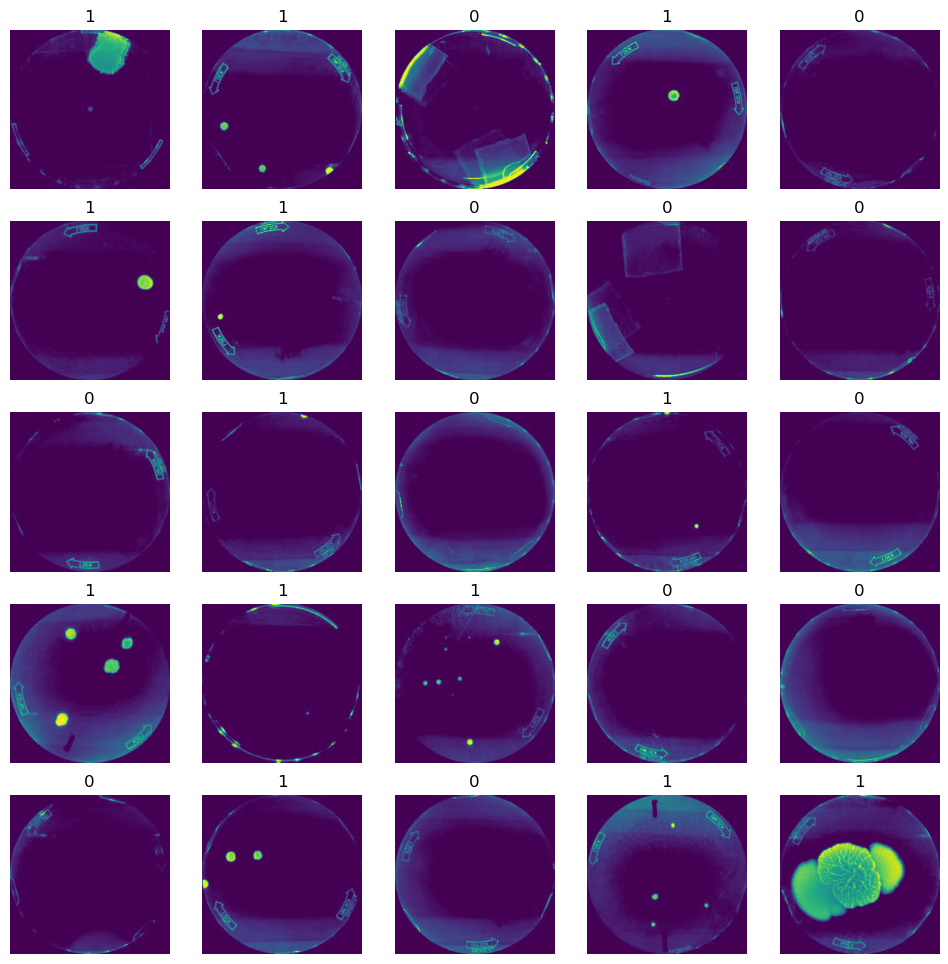

In [5]:
# Visualize first 25 images to make sure it makes sense
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    idx = 5*i+j
    image = x_train[idx]
    axs[i,j].imshow(image)
    axs[i,j].set_title(y_train[idx])
    axs[i,j].axis('off')

plt.show()

In [6]:
#Make convolutional layers

kernels = [ (np.max([int(SIZE*fraction), 3]),np.max([int(SIZE*fraction), 3])) for fraction in (0.01, 0.02, 0.04, 0.06)]

activation = 'sigmoid'

feature_extractor = Sequential()
feature_extractor.add(Conv2D(Filters , kernels[0], activation = activation, padding = 'same', input_shape = (SIZE, SIZE, IMDIM), data_format="channels_last"))
feature_extractor.add(batch_normalization.BatchNormalization())

for kernel in kernels[1:]:
    print(kernel)
    feature_extractor.add(Conv2D(Filters , kernel, activation = activation, padding = 'same', kernel_initializer = 'he_uniform'))
    feature_extractor.add(batch_normalization.BatchNormalization())
    feature_extractor.add(MaxPooling2D())

feature_extractor.add(Flatten())

#Add layers for deep learning prediction
x = feature_extractor.output  
x = Dense(128, activation = activation, kernel_initializer = 'he_uniform')(x)
prediction_layer = Dense(2, activation = 'softmax')(x)

# Make a new model combining both feature extractor and x
cnn_model = Model(inputs=feature_extractor.input, outputs=prediction_layer)
cnn_model.compile(optimizer='rmsprop',loss = 'categorical_crossentropy', metrics = ['accuracy'])
print(cnn_model.summary()) 

2023-04-07 22:40:12.817938: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-07 22:40:12.821870: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


(5, 5)
(10, 10)
(15, 15)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_input (InputLayer)   [(None, 256, 256, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      6416      
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 16)     64        
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None,

In [10]:
from tensorflow.keras.callbacks import Callback

class EarlyStoppingAtAccuracy(Callback):
    def __init__(self, threshold, acc_hist):
        super(EarlyStoppingAtAccuracy, self).__init__()
        self.threshold = threshold
        self.acc_hist = acc_hist

    def on_epoch_end(self, epoch, logs=None):
        val_accuracy = logs.get("val_accuracy")
        self.acc_hist.append(val_accuracy)
        if len(self.acc_hist) > 3 and np.median(self.acc_hist[-3:]) >= self.threshold:
            self.model.stop_training = True
            print(f"\nStopping training: Validation accuracy reached {self.threshold:.2f}")

# Set the desired accuracy threshold
accuracy_threshold = 0.9
acc_hist = []

# Create the early stopping callback
early_stopping = EarlyStoppingAtAccuracy(accuracy_threshold, acc_hist )


#Convert y to one hot encoding for use in CNN 
from keras.utils import to_categorical
y_train_one_hot = to_categorical(y_train)
y_test_one_hot = to_categorical(y_test)

# Train CNN model
history = cnn_model.fit(x_train, y_train_one_hot, epochs=100, validation_data = (x_test, y_test_one_hot), callbacks=[early_stopping])

Epoch 1/100
42/42 [==============================] - 433s 10s/step - loss: 0.0027 - accuracy: 0.9985 - val_loss: 1.0370 - val_accuracy: 0.8713
Epoch 2/100
42/42 [==============================] - 424s 10s/step - loss: 7.5480e-04 - accuracy: 1.0000 - val_loss: 0.7232 - val_accuracy: 0.9189
Epoch 3/100
42/42 [==============================] - 425s 10s/step - loss: 2.9016e-05 - accuracy: 1.0000 - val_loss: 0.9275 - val_accuracy: 0.9083
Epoch 4/100
42/42 [==============================] - ETA: 0s - loss: 0.0064 - accuracy: 0.9985
Stopping training: Validation accuracy reached 0.90
42/42 [==============================] - 428s 10s/step - loss: 0.0064 - accuracy: 0.9985 - val_loss: 0.7447 - val_accuracy: 0.8818


In [11]:
# Set up folder, unless it is already set up


now = datetime.now() # current date and time

date_time = now.strftime("%m-%d-%Y-%H-%M")
p = os.path.abspath('.')
model_dir = os.path.join(resized_dir, f'res_{SIZE}_num_flt_{Filters}_model')
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    print(f"{model_dir} created")
else:
    print(f"{model_dir} already exists")
    model_dir = model_dir+date_time

cnn_model.save(model_dir)

# Save history into a csv
with open(os.path.join(model_dir, 'hist.csv'), 'w+') as file:
  csvwriter = csv.writer(file)
  csvwriter.writerow('val_loss')
  csvwriter.writerow(history.history['val_loss'])
  csvwriter.writerow('loss')
  csvwriter.writerow(history.history['loss'])
  csvwriter.writerow('val_accuracy')
  csvwriter.writerow(history.history['val_accuracy'])
  csvwriter.writerow('accuracy')
  csvwriter.writerow(history.history['accuracy'])

/home/art_usr/source_code/CFU_counter/256/res_256_num_flt_16_model already exists


INFO:tensorflow:Assets written to: /home/art_usr/source_code/CFU_counter/256/res_256_num_flt_16_model04-08-2023-09-36/assets


INFO:tensorflow:Assets written to: /home/art_usr/source_code/CFU_counter/256/res_256_num_flt_16_model04-08-2023-09-36/assets


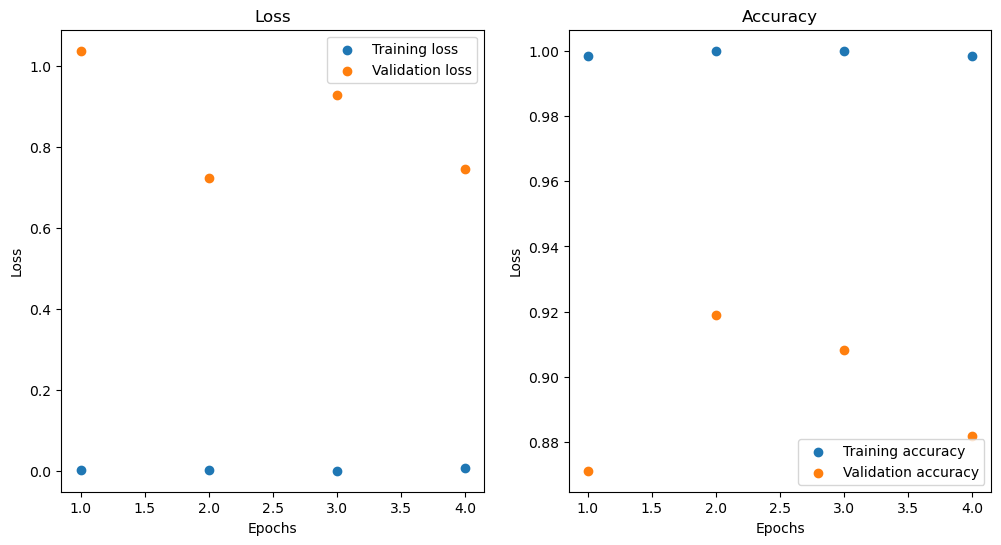

In [12]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12,6))
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
axs[0].set_title('Loss')
axs[0].scatter(epochs, loss, label = 'Training loss')
axs[0].scatter(epochs, val_loss, label = 'Validation loss')
axs[0].legend()
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Loss')
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
axs[1].set_title('Accuracy')
axs[1].scatter(epochs, accuracy, label = 'Training accuracy')
axs[1].scatter(epochs, val_accuracy, label = 'Validation accuracy')
axs[1].legend()
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')


plt.show()

18/18 [==============================] - 64s 4s/step


<AxesSubplot: >

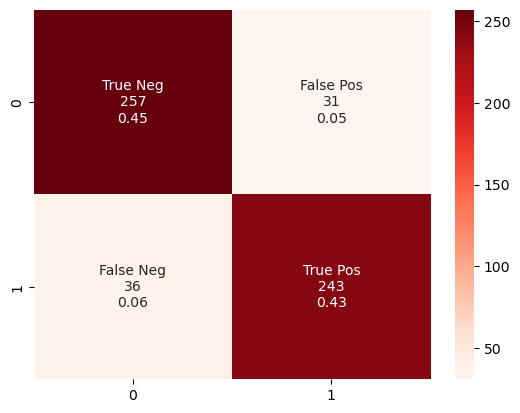

In [13]:
prediction_NN = cnn_model.predict(x_test)
prediction_NN = np.argmax(prediction_NN, axis=-1)

from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, prediction_NN)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = [f'{value}' for value in cm.flatten()]
group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

In [14]:

#  RANDOM FOREST PART
#  Now, let us use features from convolutional network for RF
from sklearn.ensemble import RandomForestClassifier
RF_model = RandomForestClassifier(n_estimators = 50, random_state = 42)

X_for_RF = feature_extractor.predict(x_train) #This will be input to RF

# Train the model on training data
RF_model.fit(X_for_RF, y_train) #For sklearn no one hot encoding

#Send test data through same feature extractor process
X_test_feature = feature_extractor.predict(x_test)
#Now predict using the trained RF model. 
prediction_RF = RF_model.predict(X_test_feature)

#Print overall accuracy
from sklearn import metrics
print ("Accuracy = ", metrics.accuracy_score(y_test, prediction_RF))

18/18 [==============================] - 61s 3s/step
Accuracy =  0.9118165784832452


<AxesSubplot: >

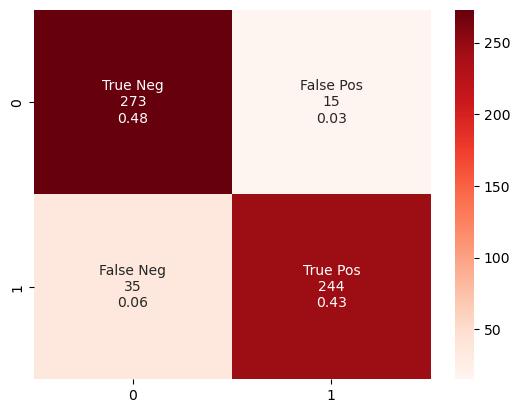

In [15]:
#Confusion Matrix - verify accuracy of each class
cm = confusion_matrix(y_test, prediction_RF)
group_names = ['True Neg','False Pos','False Neg','True Pos']
group_counts = [f'{value}' for value in cm.flatten()]
group_percentages = [f'{value:.2f}' for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt='', cmap='Reds')

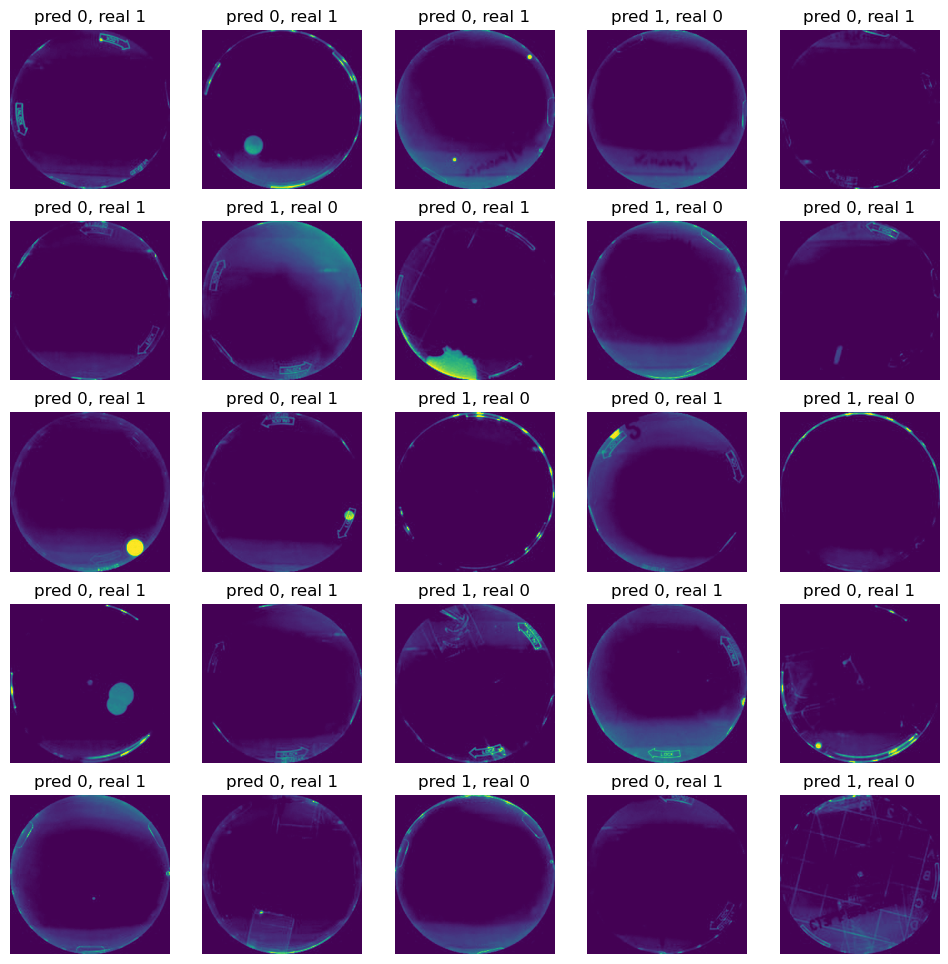

In [16]:
# Visualize 25 mistakes
error_idx = [i for i, rslt in enumerate(y_test) if (rslt + prediction_RF[i] == 1)]

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(12,12))

for i, j in [(i,j) for i in np.arange(5) for j in np.arange(5)]:
    if (5*i+j) < len(error_idx):
        idx = error_idx[5*i+j]
        axs[i,j].imshow(x_test[idx])
        axs[i,j].set_title(f'pred {int(prediction_RF[idx])}, real {int(y_test[idx])}')
        axs[i,j].axis('off')

plt.show()